## 🔎 Pre-processing of [Fake-News-Detection-dataset](https://huggingface.co/datasets/Pulk17/Fake-News-Detection-dataset)

In this notebook, we will perform some operations in order to resize the dataset.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

NUM_WORDS = "Number of words"
NUM_ARTICLES = "Number of Articles"

df = pd.read_csv("hf://datasets/Pulk17/Fake-News-Detection-dataset/train.tsv", sep="\t")

df = df.rename(columns={"Unnamed: 0": "id"})
df = df.rename(columns={"label": "is_fake_news"})
df["is_fake_news"] = df["is_fake_news"].map({0: True, 1: False})

def df_text_length():
    return df['text'].apply(
        lambda x: (len(str(x)) - len(str(x).replace(' ', '')) + 1)
        if isinstance(x, str) and str(x).strip() != '' else 0
    )
    
    
def create_histogram(ds, avg_length_article = 0.0):
    plt.hist(ds, bins=100, color='blue')
    plt.title("Distribution of News Article Lengths")
    plt.xlabel(NUM_WORDS)
    plt.ylabel(NUM_ARTICLES)
    plt.locator_params(axis='x', nbins=35)
    plt.xticks(rotation=90)
    plt.locator_params(axis='y', nbins=25)
    if avg_length_article > 0.0:
        plt.axvline(avg_length_article, color='red', linestyle='dashed', linewidth=1)
        plt.text(avg_length_article + 50, 50, f'Average Length: {avg_length_article:.2f}', color='red')
    plt.show()

c:\Users\gabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 🧾 Dataset transformation

As we saw during the dataset exploration, inside of it there are 30k articles.
<br>
However, in order to evaluate the correctness of the outputs generated by LLMs, we want to resize and filter the dataset in order to produce a more compact and non redundant one.
<br>
First of all, we will show again the distribution of the length of articles (in terms of number of words).

Maximum article length (in words): 8435
Minimum article length (in words): 1
Average article length (in words): 418.2631


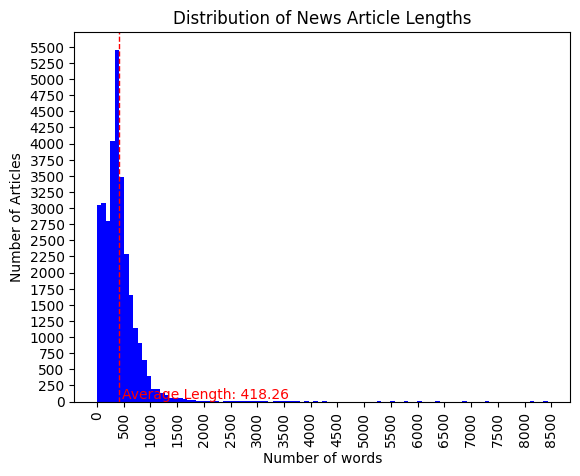

In [2]:
df['text_length'] = df_text_length()

most_length_article = df['text_length'].max()
print(f"Maximum article length (in words): {most_length_article}")

less_length_article = df['text_length'].min()
print(f"Minimum article length (in words): {less_length_article}")

avg_length_article = df['text_length'].mean()
print(f"Average article length (in words): {avg_length_article}")

create_histogram(df['text_length'], avg_length_article)

### 🧾 Deletion of duplicate rows

The datasets contains duplicated entries. We will remove them to avoid bias in the training and evaluation of the models.
We need to consider that the column ```id``` is unique for each row, so we will not consider it when looking for duplicates.

In [3]:
df = df.drop_duplicates(subset=df.columns.difference(['id']))
print("Size after removing duplicates:", df.shape)

Size after removing duplicates: (29908, 7)


### 🧾 Dataset resizing
In order to keep articles which are neither too short nor too long, we will make use of the standard deviation of the length of articles. This allow us to estabilish a range of acceptable lengths around the average length of articles.

Mean of article lengths: 417.95904105924836
Standard deviation of article lengths: 364.0079808266622
Size before filtering: 29908
Remaining articles after filtering: 2203
Article with min length after filtering: 400
Article with max length after filtering: 436


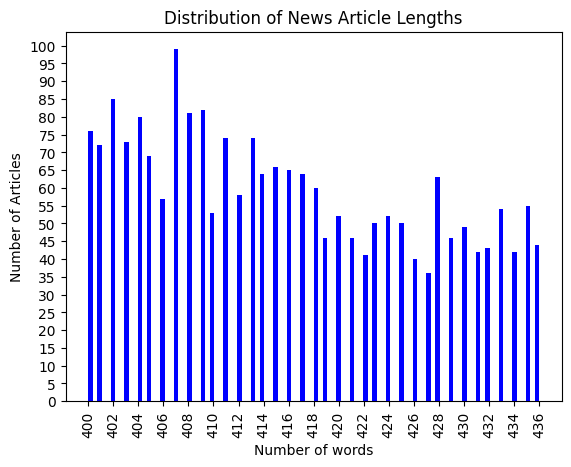

In [4]:
mean = df['text_length'].mean()
std_dev = df['text_length'].std()

print("Mean of article lengths:", mean)
print("Standard deviation of article lengths:", std_dev)

limit = 0.05 # indicates how many standard deviations from the mean we want to keep

df_filtered = df[
    (df['text_length'] >= mean - limit * std_dev) &
    (df['text_length'] <= mean + limit * std_dev)
]

print("Size before filtering:", df.shape[0])
print("Remaining articles after filtering:", df_filtered.shape[0])
print("Article with min length after filtering:", df_filtered['text_length'].min())
print("Article with max length after filtering:", df_filtered['text_length'].max())

create_histogram(df_filtered['text_length'])



As it can be seen from th histogram above, we kept articles which length is in the range [400, 430] words. This will be our new dataset of reference for the evaluation of LLMs.

In [5]:
df = df_filtered.copy()

Here a graphical representation of the number of true vs fake news articles, to show if the dataset is still balanced or not.

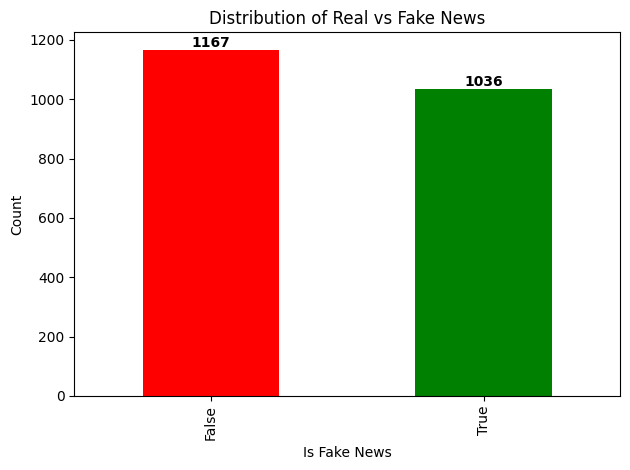

Percentage of Real News: 52.97%
Percentage of Fake News: 47.03%


In [ ]:
import matplotlib.pyplot as plt

ax = df["is_fake_news"].value_counts().plot(kind="bar", color=["red", "green"])
plt.title("Distribution of Real vs Fake News")
plt.xlabel("Is Fake News")
plt.ylabel("Count")

for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2, # type: ignore
        p.get_height(), # type: ignore
        f"{int(p.get_height())}", # type: ignore
        ha="center",
        va="bottom",   
        fontsize=10,
        fontweight="bold",
        color="black"
    )

plt.tight_layout()
plt.show()

true_news = df["is_fake_news"].value_counts(normalize=True) * 100
fake_news = df["is_fake_news"].value_counts(normalize=True) * 100
print(f"Percentage of Real News: {true_news[False]:.2f}%")
print(f"Percentage of Fake News: {fake_news[True]:.2f}%")


We can see that the dataset is quite balanced even after the filtering and resizing process.